In [56]:
# Delete numpy, then install 'gensim' and restart kernel 
!pip install gensim nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 5.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.7/782.7 KB 10.6 MB/s eta 0:00:00m eta 0:00:010:01
  Using cached tqdm-4.66.5-py3-none-any.whl (78 kB)
  Using cached click-8.1.7-py3-none-any.whl (97 kB)


In [61]:
!pip install pymorphy2 pymorphy2-dicts-ru

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 929.8 kB/s eta 0:00:0031m1.1 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 10.4 MB/s eta 0:00:00m eta 0:00:010:00:01
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for docopt, since package 'wheel' is not installed.
  Running setup.py install for docopt ... done


In [29]:
!pip uninstall numpy

In [206]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words
from sklearn.feature_extraction.text import TfidfVectorizer #  Tf–idf
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.manifold import TSNE

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re
import pymorphy2

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [6]:
habr = pd.read_csv('.tmp/habr_dataset.csv')

In [4]:
habr.columns

Index(['url', 'title', 'theme', 'tags', 'read_time', 'number_of_views', 'date',
       'amount_of_imgs', 'comments', 'bookmark', 'votes', 'text'],
      dtype='object')

In [7]:
X = habr['text']

# CountVectorizer

In [5]:
count_vectorizer = CountVectorizer()
count_vec = count_vectorizer.fit_transform(X)
count_vec.shape

(4338, 399348)

In [38]:
kmeans = KMeans(n_clusters=30, n_init = 1, init='k-means++', random_state=42)
kmeans.fit(count_vec)

KMeans(n_clusters=30, n_init=1, random_state=42)

In [39]:
kmeans.inertia_ # Сумма квадратов расстояний образцов до ближайшего центра кластера, взвешенная по весам выборок, если таковые имеются.

23948285.441837978

### При векторизации слов, с помощью CountVectorizer, слишком большая ошибка. Не имеет смысла подбирать количество кластеров

# TfidfVectorizer

In [147]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vec = tfidf_vectorizer.fit_transform(X)
tfidf_vec.shape

(4338, 399348)

In [159]:
kmeans_tfidf = KMeans(n_clusters=40, n_init = 1, init='k-means++', random_state=42)
kmeans_tfidf.fit(tfidf_vec)

KMeans(n_clusters=40, n_init=1, random_state=42)

In [160]:
kmeans_tfidf.inertia_

3863.009770661549

40 кластеров, так как при дальшем увеличении количества кластеров cумма квадратов расстояний образцов до ближайшего центра кластера теряет скорость уменьшения 'ошибки'

In [150]:
# Подбор k для KMeans с TfidfVectorizer
metrics = []
points = list(range(5, 50, 1))

neighbors = np.array(points)

for i in points:
    kmeans_tfidf = KMeans(n_clusters=i, n_init = 1, init='k-means++', random_state=42)
    kmeans_tfidf.fit(tfidf_vec)
    
    metrics.append(kmeans_tfidf.inertia_)

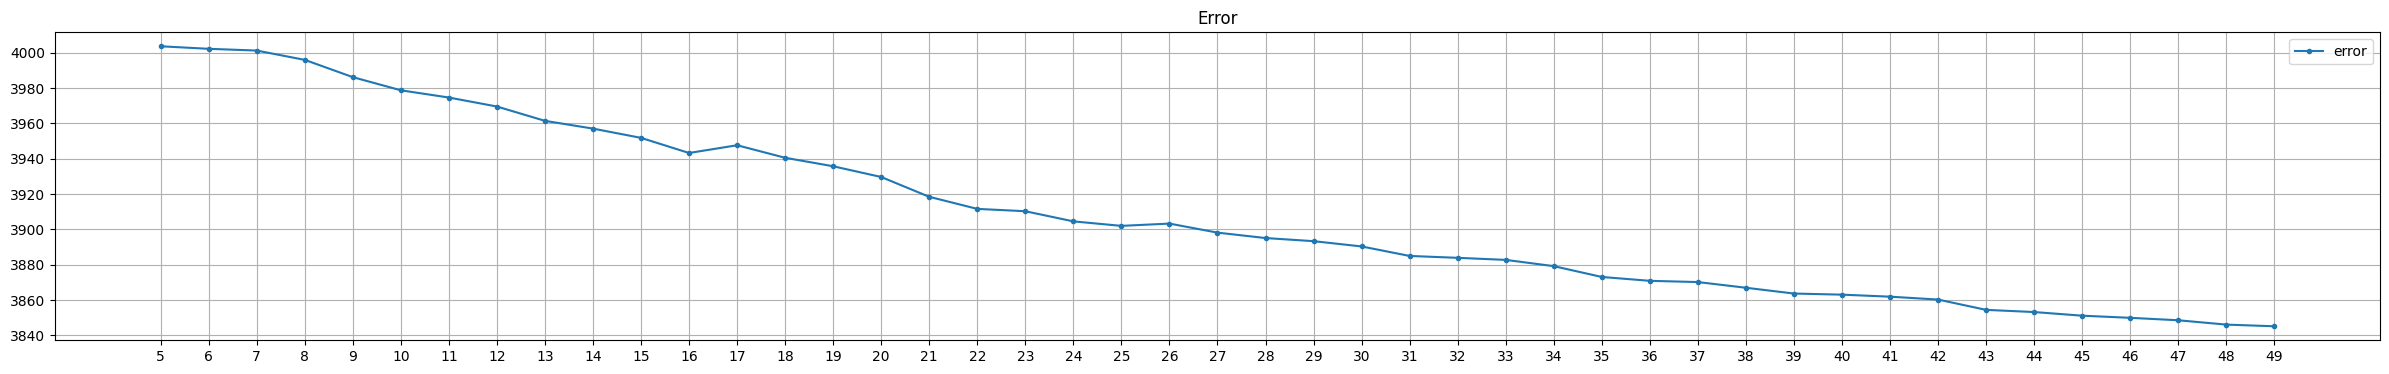

In [158]:
fig = plt.figure(figsize=(30, 4))
ax = fig.add_subplot()
ax.plot(neighbors, metrics, marker='.', label = str(i))

ax.set_title(i.capitalize())
ax.xaxis.set_major_locator(ticker.FixedLocator(neighbors))
ax.legend()
ax.grid()

# Doc2Vec

In [67]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/den/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/den/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /home/den/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [164]:
# [Fast] Очистка текста от стоп-слов и знаков пунктуации 
# stop_words = set(stopwords.words('russian'))
# def preprocess(text):
#     text = text.lower()
#     text = ''.join([char for char in text if char not in string.punctuation+'–«»➤'])
#     tokens = word_tokenize(text)
#     tokens = [word for word in tokens if word not in stop_words]
#     return ' '.join(tokens)

In [67]:
# [Slow] Очистка текста от стоп-слов и знаков пунктуации 
morph = pymorphy2.MorphAnalyzer(lang='ru')
stop_words = set(stopwords.words('russian'))

x_iter = 0

def preprocess(text):
    global x_iter

    x_iter+= 1
    
    if x_iter % 1000 == 0:
        print(x_iter)
    else:
        print(x_iter, end =',')
    
    
    text = text.lower()

    # Оставляем только текст
    symbols = re.findall("[A-Za-zА-Яа-яЁё\s]", text)
    text = ''.join(symbols)

    # Приводим все слова в начальную форму
    text = [morph.parse(word)[0].normal_form for word in text.split(' ')]
    text = ' '.join(text)
    
    tokens = word_tokenize(text)
    # Удаляем стоп-слова
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [87]:
# Обработка долгая т.к. выполняется на 1 ядре
text = X.apply(preprocess)

In [69]:
# save обработанный text
text.to_csv('full_clean_text.csv')

### Многоядерная обработка

In [83]:
x_iter = 0

In [84]:
# Разделяем текст на 5 частей
parts = 5
l = len(X)//parts
data = []
amount = 0

for i in range(parts):
    if i + 1 == parts:
        data.append(X[i*l:-1])
    else:
        data.append(X[i*l:(i+1)*l])
        
    print(len(data[i]), i*l, (i+1)*l)
    amount+=len(data[i])

print('Amount:', amount)

867 0 867
867 867 1734
867 1734 2601
867 2601 3468
869 3468 4335
Amount: 4337


In [88]:
import threading, time # потоки на 1 ядре
from multiprocessing import Process # потоки на разных ядрах

thread_list = []

def worker(i, data):
    text = data.apply(preprocess)
    text.to_csv(f'clean_text_{i}.csv')

start_time = time.time()

for i in range(5):
    thread_list.append(Process(target=worker, args=(i, data[i])))
    thread_list[i].start()

for i in range(5):
    thread_list[i].join()


end_time = time.time()
print(f'Elapsed time: {end_time-start_time}')

Elapsed time: 369.6094262599945

In [98]:
# Объединяем полученные результаты обработки
data = []

for i in range(parts):
    data.append(pd.read_csv(f'clean_text_{i}.csv', index_col=0))

df = pd.concat(data)
df.shape

(4337, 1)

In [99]:
df.to_csv('full_clean_text_1.csv')

### Модель Doc2Vec

In [100]:
import statistics

# Получаем среднюю длину текста
length = [len(i) for i in text]
print('Average:', sum(length)/len(text))
print('Median:', statistics.median(length))

Average: 11972.657676348548
Median: 10234.5


In [101]:
data = [TaggedDocument(words = word_tokenize(doc), tags=[str(i)]) for i, doc in enumerate(text)]
# data

In [103]:
# Обучаем  Doc2vec модель
model = Doc2Vec(vector_size=100, min_count=10, epochs=50,  window=3)
model.build_vocab(data)
model.train(data, total_examples=model.corpus_count, epochs=model.epochs)

In [104]:
model.save('doc2vec.model')

In [105]:
model.dv.most_similar('0')

[('4203', 0.527695894241333),
 ('2601', 0.5004347562789917),
 ('4077', 0.5001001954078674),
 ('700', 0.49752482771873474),
 ('1743', 0.49234187602996826),
 ('2152', 0.4822539687156677),
 ('2976', 0.4795401990413666),
 ('4115', 0.476169228553772),
 ('1301', 0.4761359393596649),
 ('413', 0.47057223320007324)]

In [106]:
document_vectors = [model.infer_vector( word_tokenize(doc)) for doc in text]

# #  Распечатаем вектора документов
# for i, doc in enumerate(data):
#     print("Document", i+1, ":", doc)
#     print("Vector:", document_vectors[i])
#     print()

In [143]:
kmeans_d2v = KMeans(n_clusters=20, n_init = 1, init='k-means++', random_state=42)
kmeans_d2v.fit(document_vectors)

KMeans(n_clusters=20, n_init=1, random_state=42)

In [157]:
def metrics_text(model, x):
    print(f"Сумма квадратов расстояний до ближайшего центра: {model.inertia_}")
    
    silhouette = silhouette_score(x, model.labels_)
    db_index = davies_bouldin_score(x, model.labels_)
    ch_index = calinski_harabasz_score(x, model.labels_)
    
    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")

def metrics_json(model, x):
    return {
        'error': model.inertia_,
        'silhouette': silhouette_score(x, model.labels_), 
        'db_index': davies_bouldin_score(x, model.labels_), 
        'ch_index': calinski_harabasz_score(x, model.labels_)
    }

In [146]:
metrics_text(kmeans_d2v, document_vectors)

Сумма квадратов расстояний до ближайшего центра: 908530.4521209723
Silhouette Score: 0.05
Davies-Bouldin Index: 3.43
Calinski-Harabasz Index: 67.10


**Silhouette Score:** 
Этот показатель показывает, насколько похожи точки данных внутри своих кластеров 
по сравнению с точками данных из других кластеров. Результат 0,55 
указывает на то, что между кластерами есть некоторое разделение, но 
но еще есть пространство для улучшения. Значения, близкие к 1, указывают на 
более четкие кластеры.
    
**Davies-Bouldin Index:**
 Этот индекс рассчитывает среднее сходство между каждым кластером и 
его ближайшими соседями. Более низкий показатель предпочтительнее, а 0,66 говорит о 
довольно сильное разделение между кластерами.

**Calinski-Harabasz Index:**
 рассчитывает отношение межкластерной вариации к внутрикластерной 
дисперсии. Более высокие значения указывают на более четкое разделение групп. Ваши кластеры 
отчетливыми и независимыми с показателем 561,63.


In [139]:
metrics = { 'error': [],'silhouette':[], 'db_index': [], 'ch_index': []}
points = list(range(5, 100, 1))

neighbors = np.array(points)

for i in points:
    kmeans_d2v = KMeans(n_clusters=i, n_init = 1, init='k-means++', random_state=42)
    kmeans_d2v.fit(document_vectors)
    
    m = metrics_json(kmeans_d2v, document_vectors)

    for i in metrics.keys():
        metrics[i].append(m[i])

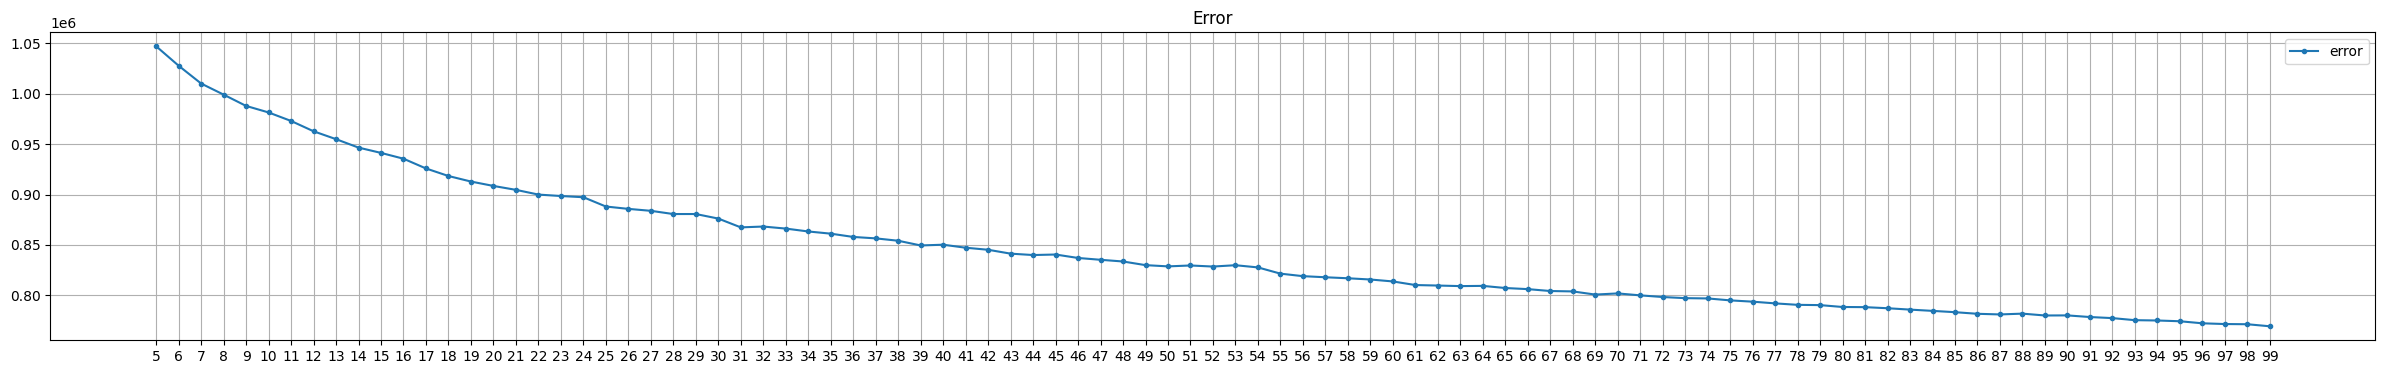

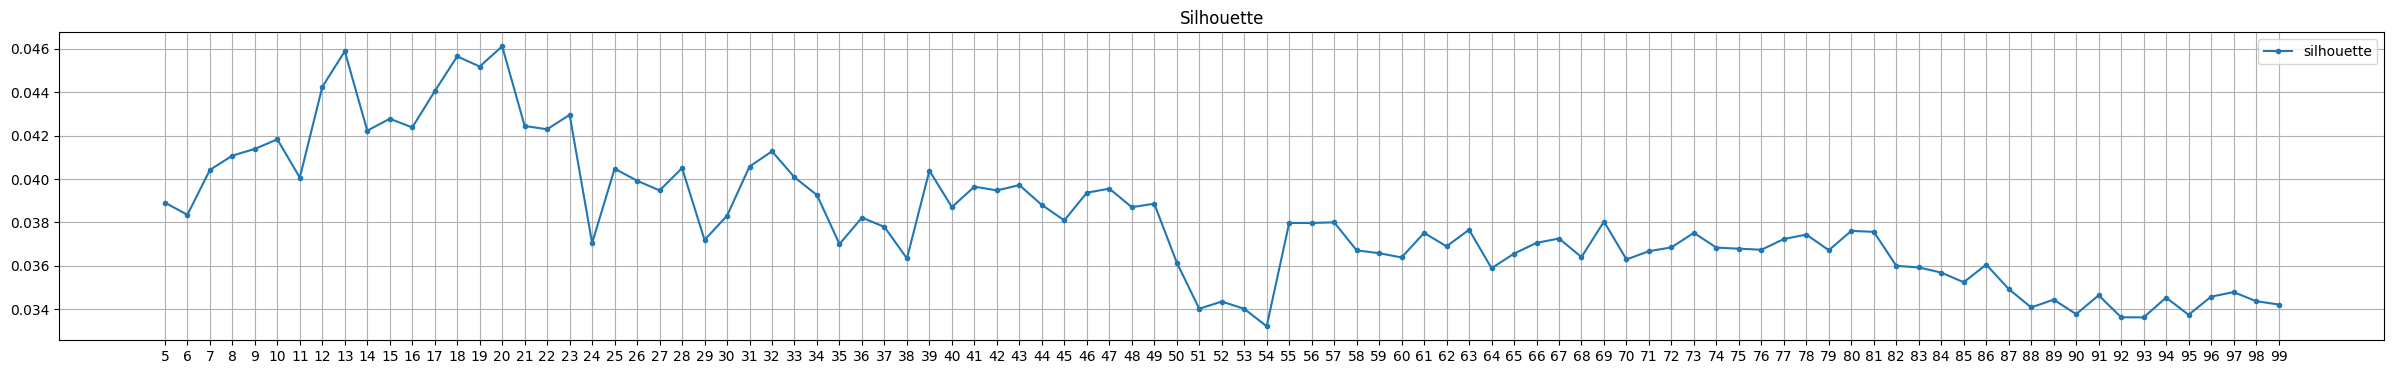

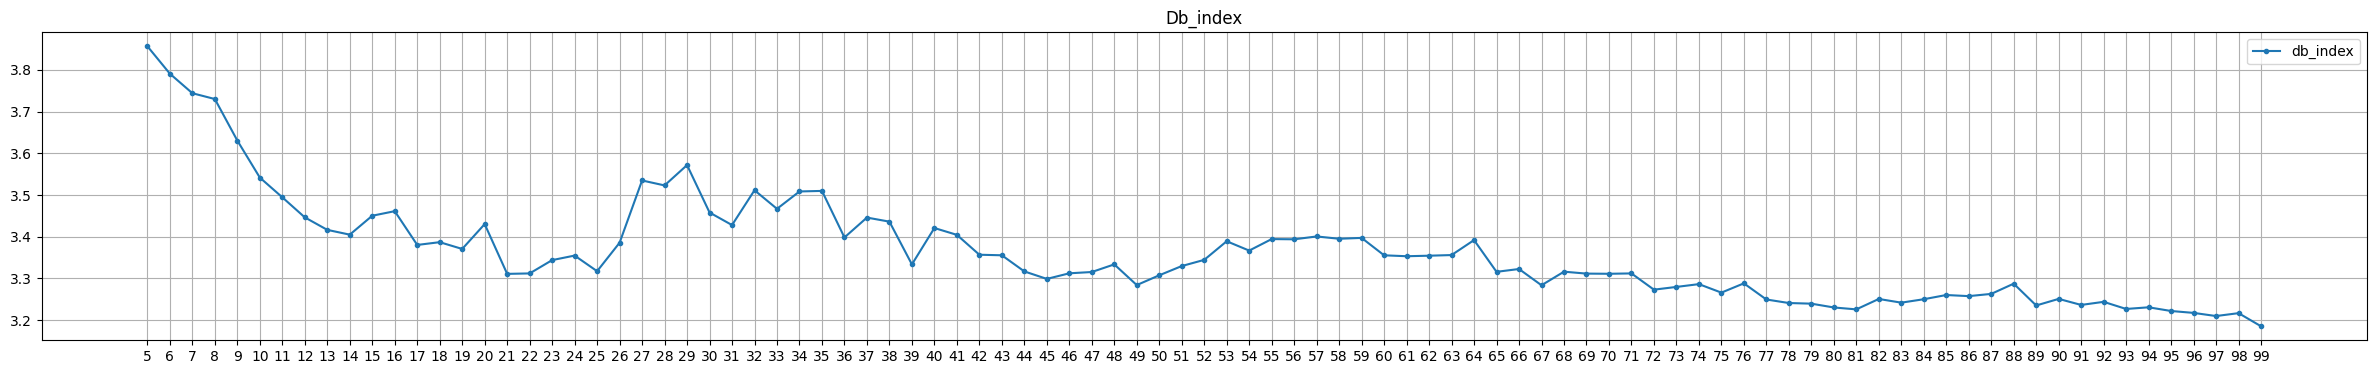

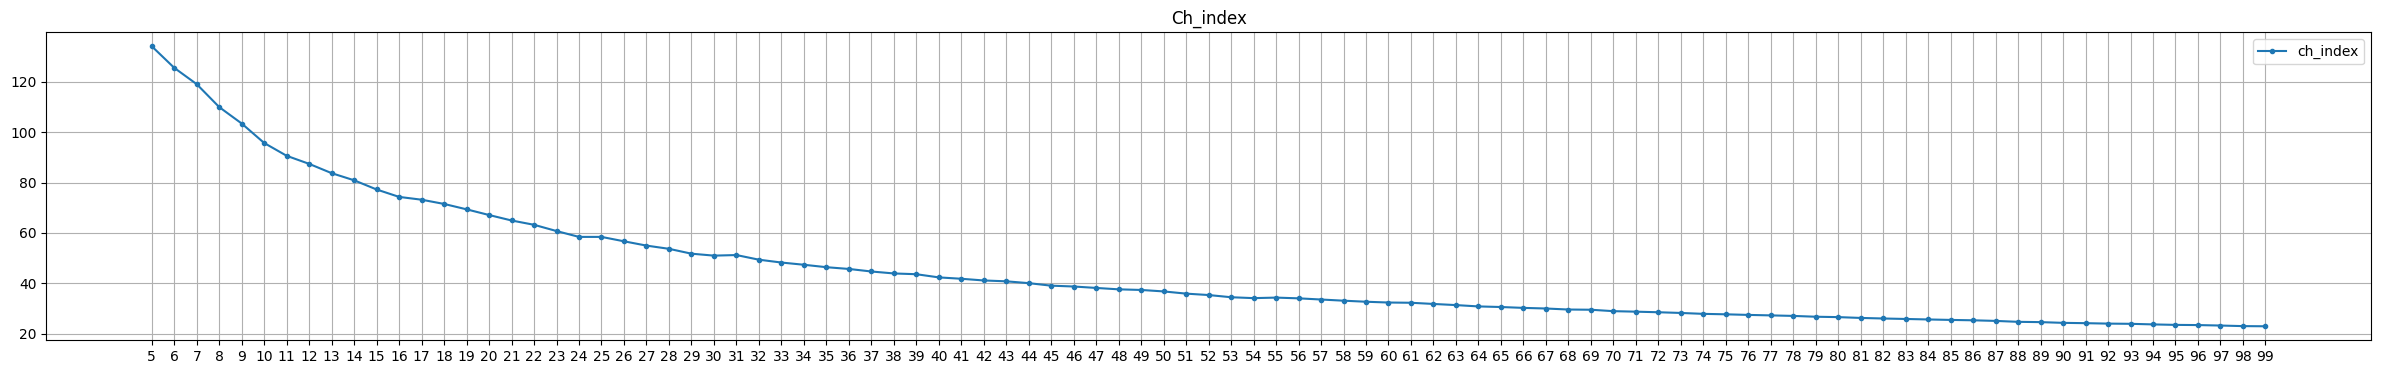

In [140]:
for i in metrics.keys():
    fig = plt.figure(figsize=(30, 4))
    ax = fig.add_subplot()
    ax.plot(neighbors, metrics[i], marker='.', label = str(i))

    ax.set_title(i.capitalize())
    ax.xaxis.set_major_locator(ticker.FixedLocator(neighbors))
    ax.legend()
    ax.grid()

# Word2Vec

In [174]:
df = pd.read_csv('full_clean_text.csv', index_col=0)

In [175]:
texts = [df.text.iloc[i].split() for i in range(len(df))]

In [176]:
model = Word2Vec(texts, window=5, min_count=5, workers=5)
model.save("word2v.model")
#model = Word2Vec.load("word2v.model")

In [180]:
model.wv.most_similar("китай")

[('япония', 0.916832685470581),
 ('индия', 0.8772345185279846),
 ('европа', 0.8302344083786011),
 ('россия', 0.8155491352081299),
 ('германия', 0.8084151148796082),
 ('тайвань', 0.8066524267196655),
 ('канада', 0.8064517378807068),
 ('кнр', 0.8009989261627197),
 ('сша', 0.800139844417572),
 ('франция', 0.7876429557800293)]

In [183]:
model.wv.most_similar("бриллиант")

[('труха', 0.8526841998100281),
 ('хлопчатник', 0.8332104086875916),
 ('вкрапление', 0.8310204148292542),
 ('ив', 0.827011227607727),
 ('зёрнышко', 0.8255564570426941),
 ('драгоценность', 0.82452791929245),
 ('апельсин', 0.8228102326393127),
 ('пантера', 0.8224404454231262),
 ('осмий', 0.821290135383606),
 ('fregg', 0.8132267594337463)]

In [185]:
model.wv.most_similar("пришелец")

[('инопланетянин', 0.8096006512641907),
 ('марсианин', 0.8005115985870361),
 ('тварь', 0.7957400679588318),
 ('монстр', 0.7844758033752441),
 ('охотник', 0.779679000377655),
 ('ужас', 0.76441490650177),
 ('нибира', 0.7576026916503906),
 ('божество', 0.756729006767273),
 ('рептилоида', 0.7517012357711792),
 ('всемогущий', 0.7500805854797363)]

In [187]:
model.wv.get_vector("золото")

array([-1.629101  , -1.138931  ,  2.3038838 ,  0.2045949 ,  0.16923319,
       -0.84295964,  0.01204165,  2.5265925 ,  1.1937561 ,  0.2135045 ,
        0.7031586 , -0.97443664, -0.2766761 ,  1.3023005 ,  0.79609936,
       -1.2007197 ,  0.04294499, -1.080707  , -1.3619565 ,  0.19793074,
       -0.83331156, -0.8980814 , -0.11488109, -0.33775637, -0.525354  ,
       -0.3547098 , -1.03808   , -0.40228975,  0.82475865, -0.19105785,
        0.07271919, -0.19298624, -0.31564116, -1.9374725 ,  0.6073338 ,
        0.685462  ,  0.9925832 ,  0.19593565, -0.44996488, -0.02488068,
        0.756407  ,  0.67219603,  1.0240194 ,  1.3027267 ,  1.1648618 ,
        1.3154721 ,  0.8957017 ,  1.2047131 , -0.7950886 ,  0.05496327,
        0.24118258, -1.3920228 , -0.15356746,  0.71195865, -0.16912252,
        1.7578561 ,  0.17484458, -0.3883545 , -1.2809722 ,  0.30354324,
       -1.0592846 , -0.31812218, -1.107082  , -0.8680479 , -0.77826935,
        0.6317854 ,  2.0869687 ,  0.53396004, -0.6266724 ,  0.81

In [192]:
vec = (model.wv['пришелец'] - model.wv['человек'] + model.wv['марс'])/3
model.wv.similar_by_vector(vec)

[('энцелада', 0.7160701751708984),
 ('ио', 0.6886510848999023),
 ('марсианский', 0.6763332486152649),
 ('ганимед', 0.6735153794288635),
 ('марс', 0.6684213876724243),
 ('сатурн', 0.6610293984413147),
 ('венера', 0.6556771397590637),
 ('лунный', 0.6496171355247498),
 ('probe', 0.6465002298355103),
 ('кьюриосити', 0.6427473425865173)]

In [199]:
model.wv.doesnt_match("дельфин жираф осминог дельфин".split())

'жираф'

In [200]:
top_words = []
from nltk import FreqDist
fd = FreqDist()
for text in texts:
    fd.update(text)
for i in fd.most_common(100):
    top_words.append(i[0])
print(top_words)

['это', 'который', 'мочь', 'год', 'всё', 'весь', 'свой', 'время', 'человек', 'система', 'ещё', 'большой', 'первый', 'наш', 'также', 'новый', 'стать', 'работа', 'использовать', 'очень', 'иметь', 'самый', 'являться', 'каждый', 'результат', 'часть', 'например', 'модель', 'несколько', 'получить', 'должный', 'учёный', 'работать', 'случай', 'больший', 'мир', 'исследование', 'процесс', 'вид', 'проблема', 'хороший', 'дать', 'помощь', 'энергия', 'просто', 'число', 'её', 'скорость', 'сделать', 'некоторый', 'количество', 'звезда', 'разный', 'поэтому', 'именно', 'говорить', 'высокий', 'однако', 'компания', 'жизнь', 'вода', 'данные', 'земля', 'друг', 'точка', 'информация', 'объект', 'уровень', 'вопрос', 'нужно', 'ть', 'показать', 'любой', 'задача', 'место', 'позволять', 'делать', 'состояние', 'образ', 'момент', 'статья', 'решение', 'находиться', 'изображение', 'технология', 'день', 'метод', 'дело', 'материал', 'мозг', 'возможность', 'простой', 'сторона', 'качество', 'использование', 'космический', 

In [202]:
top_words_vec = model.wv[top_words]
top_words_vec.shape

(100, 100)

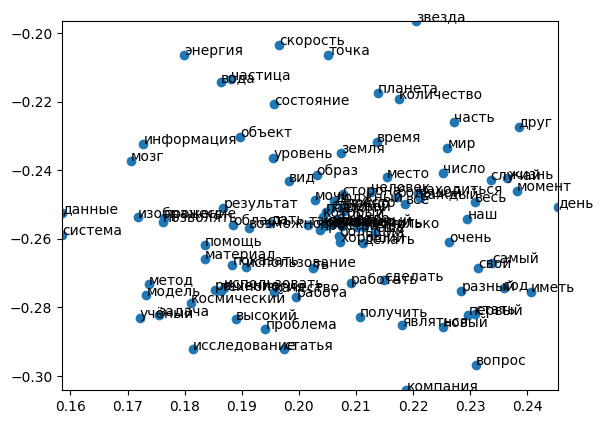

<Figure size 2000x480 with 0 Axes>

In [205]:
def display_top_words_tsnescatterplot(model, top_words_vec, top_words):

    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0, perplexity=top_words_vec.shape[0] - 1)
    np.set_printoptions(suppress=True)


    Y = tsne.fit_transform(top_words_vec)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(top_words, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)

    plt.figure().set_figwidth(20)
    plt.show()


display_top_words_tsnescatterplot(model, top_words_vec, top_words)

In [251]:
# Получаем все слова
unique_words = set()

for i, words in enumerate(texts):
    unique_words.update(set(words))
    
unique_words, len(unique_words)

({'вышенаиболее',
  'сосудик',
  'негокутузов',
  'cuhk',
  'теплопотребление',
  'rdбизнес',
  'меймана',
  'valueposter',
  'подобострастно',
  'лямбдаcdmть',
  'redoxredox',
  'перегиб',
  'желтосиний',
  'netowrkflow',
  'продуктовва',
  'вещамивопервое',
  'выстуживать',
  'терапиикстати',
  'началоести',
  'котенев',
  'трипод',
  'ложечкой',
  'immortal',
  'активированный',
  'исчезает',
  'размеровнаш',
  'лучейфиламент',
  'дманися',
  'анемией',
  'ангидробиоз',
  'грусть',
  'кривизнапримечание',
  'знаковмониторинг',
  'съемок',
  'числовой',
  'островград',
  'бромсодержать',
  'precession',
  'отпускпадение',
  'мелководье',
  'mcdonnell',
  'выкристаллизоваться',
  'годуотклонение',
  'тюрк',
  'infoworld',
  'статьеалгоритм',
  'разъёмыкраевой',
  'тепловыделять',
  'переводаположение',
  'гештальттерапия',
  'окончания',
  'истинностина',
  'черпать',
  'linuxмашин',
  'robson',
  'chandrasekhar',
  'микрорайонный',
  'аминептин',
  'ведие',
  'зовпение',
  'платониче

In [259]:
word_dict = pd.DataFrame(columns=['word', 'vec'])

for i, word in enumerate(unique_words):
    try:
        word_dict.loc[i] = {'word': word, 'vec': model.wv.get_vector(word).tolist()}
    except:
        pass

word_dict

,word,vec
11,перегиб,"[0.001673389575444162, 0.29032009840011597, -0..."
23,активированный,"[-0.08903951942920685, 0.051132846623659134, 0..."
24,исчезает,"[-0.09491389989852905, -0.013209131546318531, ..."
30,грусть,"[-0.13278961181640625, 0.1985543668270111, 0.2..."
32,знаковмониторинг,"[-0.20866648852825165, 1.2224395275115967, 0.0..."
...,...,...
298188,подъёмник,"[-0.058060817420482635, 0.08243758976459503, 0..."
298193,прайминг,"[-0.04588340222835541, 0.03785109892487526, 0...."
298214,contest,"[0.006145489867776632, 0.05155143141746521, -0..."
298219,mathematica,"[-0.06964319199323654, 0.09532644599676132, 0...."


In [260]:
word_dict.to_csv('word_vec_dict.csv')

In [274]:
kmeans_w2v = KMeans(n_clusters=2000, n_init = 1, init='k-means++', random_state=42)
kmeans_w2v.fit(word_dict['vec'].tolist())

KMeans(n_clusters=2000, n_init=1, random_state=42)

In [275]:
kmeans_w2v.inertia_

111742.79303679263

In [276]:
pred = kmeans_w2v.predict(word_dict['vec'].tolist())

In [278]:
word_dict['class']=pred

In [282]:
word_dict[word_dict['class']==3] # Слова, которые оказались в одном кластере

,word,vec,class
253,компании,"[0.016319923102855682, 0.5840969085693359, 0.1...",3
385,правительственный,"[0.20533674955368042, 0.2877078652381897, 0.25...",3
961,наработка,"[-0.05368649214506149, 0.3579409420490265, -0....",3
6012,страховой,"[0.06057862192392349, 0.4566623568534851, -0.0...",3
10751,призвать,"[-0.05699287727475166, 0.6893075108528137, 0.0...",3
19095,перепись,"[0.42894405126571655, -0.15926425158977509, 0....",3
20882,ооо,"[0.06650637090206146, 0.7369429469108582, -0.4...",3
26240,конструкторский,"[-0.024441102519631386, 0.40145042538642883, -...",3
37938,att,"[0.1324574500322342, 0.3885303735733032, -0.36...",3
42544,концерн,"[0.02437150850892067, 0.5616240501403809, 0.16...",3
